# Extraction de variables sociodémographiques à partir de données textuelles
## ANSELME MARTIN Maxime

L’objectif de ce travail est de montrer un exemple concret d'extraction d’informations sociodémographiques à partir de descriptions. Je vais me focaliser sur deux variables à extraire : **l'âge** et la **ville de naissance**.

Les principales étapes sont :

1. **Création d’un jeu de données** représentatif du type de textes rencontrés, avec variations et fautes réalistes.
2. **Prétraitement linguistique** : uniformisation et nettoyage des textes.
3. **Analyse exploratoire** pour identifier les motifs linguistiques utiles à l’extraction.  
4. **Extraction automatique de variables** à l’aide de règles (regex) et d’analyses contextuelles.  
5. **Discussion des limites et perspectives d’amélioration**

In [107]:
#Import des librairies

import pandas as pd
import spacy
import matplotlib.pyplot as plt
from typing import List, Optional
import re
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
from rapidfuzz import process
from wordcloud import WordCloud

pd.set_option('display.max_colwidth', None)

### 1 - Génération des données textuelles simulées

Les données ci-dessous ont été générées à l’aide d’un modèle de langage (ChatGPT).  
L’objectif est de créer un jeu de textes représentatif de situations variées (profils de patients, statuts sociaux, professions...), tout en introduisant volontairement :

- des **variations lexicales** : synonymes et formulations différentes (`à la retraite`, `retraité`, `pensionné`...)  
- des **formes syntaxiques multiples** pour l’âge (`25 ans`, `âge de 25 ans`, `25 année`...)  
- des **fautes de frappe** réalistes (`femmee`, `zns`, `anée`, `avocatte`...)  
- des **formes syntaxiques multiples** pour la ville de naissance : chaque texte mentionne une **ville de naissance** (ex. `née à`, `né dans l’hôpital de`, `originaire de`, `natale de`...), et j’ai volontairement introduit des mentions à d’autres villes dans les textes (ex. `née à Orléans, vit à Metz`).


In [236]:
data = {
    "text": [
        "Patiente âgée de 72 ans, née à Pariis, veuve, vit seule à domicile. Ancienne enseignante.",
        "Homme de 45 ans, marié, chauffeur routier, originaire de Lyon, hébergé avec sa famille à Lyon.",
        "Étudiante de 23 ans, née à l'hopital d'Annecy, célibataire, vit en colocation à Marseile.", 
        "Femme, 35 ans, infirmière, natale de Toulose, vivant avec son conjoint et un enfant à Toulouse.",
        "Homme, 50 ans, ingénieur, née à Nice, marié, passionné de sport depuis quelques années.",
        "Patiente 29a, professeure, née à Bonneval-sur-Arc, célibataire, vit en appartement en périphérie de Lille.",  
        "Femme âgée de 61 ans, à la retraite, originaire de Strasbourg, vit seule à Strasbourg.",
        "Étudiant 21 ans, née à Rennes, informaticien, en colocation",
        "Résidant à Montpellier, age : 40, nee à Montpellier, chauffeur, marié, 3 enfants.",
        "Patiente, 27 ans, avocate, née à Bordeaux, célibataire, vit en ville à Bordeaux.",
        "Mariée et patiente de 25 ans, originaire de Nantes, elle vit à Nantes, en centre-ville.",
        "Homme 38 ans, chauffeur, née à Dijon, célibataire, installé à Dijon depuis 2 ans.",
        "Étudiante de 22 ans, néée à Grenoble, en colocation à Grenoble, aime le sport.",
        "Femme âgée d’environ 31 ans, enseignante, née et vit à Angers",
        "Homme, 44 ans, ingénieur, marié, deux enfants, né à Lyon.",
        "Patiente, 28 ans, avocate, née à Tours, célibataire, vit en appartement à Tours depuis peu.",
        "Femme de 33 ans, infirmière, originaire de Reims, y vit avec son conjoint.",
        "Étudiant de 20a, informaticien, née à Orléans, en colocation à Orléans.", 
        "Homme, environ 47 ans, professeur, marié, 1 enfant, née a Orléans, vit à Metz.",
        "Patiente de 26 années, pensionnée, née à Caen, vit seule à Paris.",
        "Monsieur âgé de 58 ans, retraité, originaire de Perpignan, vit à la campagne près de Perpignan.",
        "Passionnée de jardinage, femme d’une cinquantaine d’années, née à Saint-Étienne, à la retraite.",
        "Jeune homme de 19 ans, étudiant, natale de Mulhouse, vit avec ses parents à Mulhouse.",
        "Patiente de 30 an, enseignante, née à Pau, vit en ville à Tarbes.",
        "Femme 32 ans, aide-soignante, mariée, deux enfants, née à Zmiens, vit à Amiens.",
        "Homme âgé de 60 ans, retraité, originaire d’Avignon, vit seul à Avignon.",
        "Patiente âgée de 70 ans, veuve, néé à Troyes, vit seule à domicile à Troyes.",  
        "Homme de 48 ans, en préretraite, natale de Calais, vit avec son épouse à Calais.",
        "Patiente, environ 24 zns, étudiante infirmière, née à Belfort, vit à Belfort.",
        "Monsieur de 55 ans, ancien ouvrier, pensionné, née à l'hopital de La Rochelle.",
    ]
}

df = pd.DataFrame(data)

## 2 - Prétraitement du texte

**Étapes réalisées :**  
1. **Passage en minuscules** : uniformise le texte (`Lyon`→ `lyon`).  
2. **Suppression des accents** : simplifie la recherche et le matching des mots (`âgé` → `age`).  
3. **Suppression de la ponctuation** : élimine les caractères inutiles qui peuvent compliquer la tokenisation.  
4. **Nettoyage des espaces multiples et trimming** : rend le texte homogène.  
5. **Suppression des stopwords** : réduit le bruit et concentre l’analyse sur les mots porteurs d’information.  

**Limites et ajustements possibles :**  
- Certains mots ou ponctuations supprimés peuvent être utiles pour l’extraction de variables spécifiques. Le pipeline peut donc être ajusté selon la tâche finale et la structure des textes.  
- Ici, on utilise une liste de stopwords du package **nltk**, mais il peut être pertinent de l’adapter en fonction du contexte spécifique des textes analysés.  


In [237]:
# Télécharger les stopwords si pas déjà fait
#nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

def preprocess(text: str) -> str:
    """
    Prétraitement du texte pour NLP.

    Args:
        text (str): Texte brut

    Returns:
        str: Texte nettoyé 
    """

    text = text.lower() #Passage en minuscules
    text = unidecode(text) # Suppression des accents
    text = re.sub(r'[^\w\s]', '', text) # Suppression de la ponctuation
    text = re.sub(r'\s+', ' ', text) # Suppression des espaces multiples
    text = text.strip()  # Suppression des espaces en début et fin
    
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Suppression des stopwords
    text = ' '.join(words)
    
    return text

df['text_clean'] = df['text'].apply(preprocess)

## Quelques lignes nettoyées :

In [238]:
df[["text","text_clean"]].head(3)

,text,text_clean
0,"Patiente âgée de 72 ans, née à Pariis, veuve, vit seule à domicile. Ancienne enseignante.",patiente agee 72 ans nee a pariis veuve vit seule a domicile ancienne enseignante
1,"Homme de 45 ans, marié, chauffeur routier, originaire de Lyon, hébergé avec sa famille à Lyon.",homme 45 ans marie chauffeur routier originaire lyon heberge famille a lyon
2,"Étudiante de 23 ans, née à l'hopital d'Annecy, célibataire, vit en colocation à Marseile.",etudiante 23 ans nee a lhopital dannecy celibataire vit colocation a marseile


## 3 - Analyse exploratoire pour l'extraction d'âge

Avant d'extraire les âges des textes, il est crucial de comprendre le contexte dans lequel apparaissent les nombres.  
Cette étape permet de construire un regex fiable.

**Étapes réalisées :**
1. Extraction de tous les nombres dans le texte avec un contexte de quelques mots autour.  
2. Analyse des mots les plus fréquents **avant** et **après** chaque nombre pour identifier des motifs indiquant un âge (`ans`, `a`, `an`, `année`).  
3. Utilisation de ces motifs pour construire un regex robuste qui capture la majorité des variantes d’âge (ex: `25 ans`, `25a`, `25 année`).


In [239]:
def extract_number_context(text: str, window: int = 1 ) -> List[str]:
    """
    Extrait les nombres présents dans un texte avec leur contexte.

    Args:
        text (str): Le texte à analyser.
        window (int): Nombre de mots à inclure avant et après chaque nombre détecté.

    Returns:
        List[str]: Liste de tokens comprenant tous les nombres et leurs mots voisins.
    """
    words = text.split()
    results = []
   
    for i, word in enumerate(words):
        if re.search(r'\d+', word):
            start = max(i - window, 0)
            end = min(i + window + 1, len(words))
            context_tokens = words[start:end]
            results.extend(context_tokens)  
    
    return results

df['context'] = df['text_clean'].apply(extract_number_context)

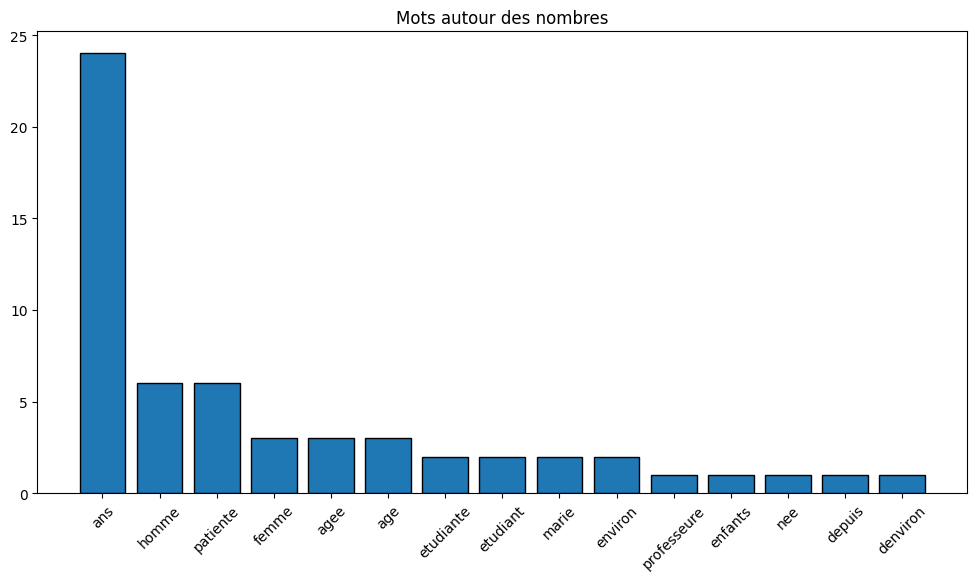

In [240]:
 all_words = pd.Series([word for tokens in df['context'] for word in tokens]) 

# Filtrer les nombres 
all_words_no_numbers = all_words[~all_words.str.contains(r'\d+')] 

# Compter les occurrences 
word_counts_df = all_words_no_numbers.value_counts().reset_index()
word_counts_df.columns = ['word', 'count'] 
top_words_df = word_counts_df.head(15) 

# Visualisation 
plt.figure(figsize=(12,6)) 
plt.bar(top_words_df['word'], top_words_df['count'], edgecolor="black") 
plt.xticks(rotation=45) 
plt.title("Mots autour des nombres") 
plt.show()

## Extraction de l'âge par Regex

Pour extraire les âges, j'ai construit un regex basé sur l'analyse des contextes autour des nombres.  
Grâce à l'analyse exploratoire, j'ai identifié que les âges étaient souvent suivis de motifs comme `ans`, `a`, `an`, `annee` ou `annees`.  

On construit le regex suivant :

In [241]:
def extract_age(text: str) -> int | None:
    """
    Extrait l'âge d'un texte prétraité en capturant plusieurs variantes.

    Args:
        text (str): Texte nettoyé (minuscules, ponctuation supprimée, etc.).

    Returns:
        int | None: L'âge extrait si trouvé, sinon None.
    """
    pattern = r'(\d{1,3})\s?(?:a|an|ans|année|années)'
    match = re.search(pattern, text)
    if match:
        return int(match.group(1))
        if 1 <= age <= 120: # On filtre sur une plage cohérente avec la donnée extraite.
            return age
    return pd.NA


In [242]:
df['age'] = df['text_clean'].apply(extract_age)
df[['text','age']].head(3)

,text,age
0,"Patiente âgée de 72 ans, née à Pariis, veuve, vit seule à domicile. Ancienne enseignante.",72
1,"Homme de 45 ans, marié, chauffeur routier, originaire de Lyon, hébergé avec sa famille à Lyon.",45
2,"Étudiante de 23 ans, née à l'hopital d'Annecy, célibataire, vit en colocation à Marseile.",23


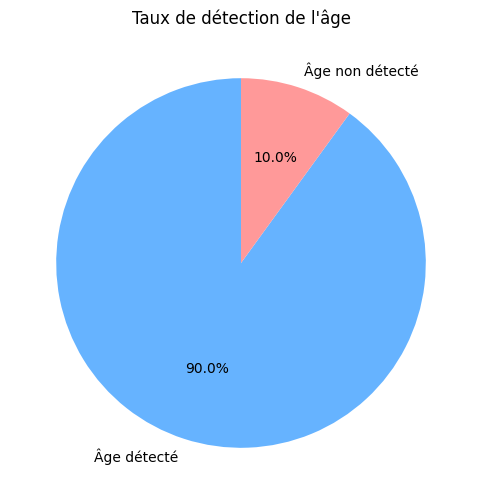

In [243]:
# Taux de détection de l'âge :
# Attention : ce graphique ne nous donne pas d'informations si l'age detecté est valide ou non.

nb_total = df.shape[0]
nb_non_detecte = df[df['age'].isnull()].shape[0]
nb_detecte = nb_total - nb_non_detecte

labels = ['Âge détecté', 'Âge non détecté']
values = [nb_detecte, nb_non_detecte]
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Taux de détection de l'âge")
plt.show()

### Exemple de lignes où l’âge n’a pas été détecté par la regex :


In [244]:
df[df['age'].isnull()][['text','text_clean','age']].head(3)

,text,text_clean,age
8,"Résidant à Montpellier, age : 40, nee à Montpellier, chauffeur, marié, 3 enfants.",residant a montpellier age 40 nee a montpellier chauffeur marie 3 enfants,<NA>
21,"Passionnée de jardinage, femme d’une cinquantaine d’années, née à Saint-Étienne, à la retraite.",passionnee jardinage femme dune cinquantaine dannees nee a saintetienne a retraite,<NA>
28,"Patiente, environ 24 zns, étudiante infirmière, née à Belfort, vit à Belfort.",patiente environ 24 zns etudiante infirmiere nee a belfort vit a belfort,<NA>


## Limites de l'extraction d'âge

Même si le regex que nous avons construit est robuste pour la majorité des cas, il existe quelques limites à noter :

1. **Nombres écrits en lettres**  
   - Exemple : `"Deux ans"` ne sera pas détecté par le regex qui ne capture que les chiffres (`\d+`).  
   - Solution possible : utiliser un module de conversion de mots en nombres (`word2number`) ou des règles supplémentaires.

2. **Suppression de la ponctuation**  
   - Lors du prétraitement, la suppression de la ponctuation peut compliquer certains cas.  
   - Exemple : `"Homme, 25, étudiant"` → Dans certains cas, la ponctuation peut être utile pour détecter correctement les âges et éviter les ambiguïtés.

3. **Variantes et fautes typographiques**  
   - Les formes très inhabituelles ou les fautes de frappe peuvent ne pas être capturées (Exemple : `age : 40`, `24 zns`)

**Conclusion :**  
Le pipeline fonctionne bien pour les formats courants. Il s’agit aussi de trouver un compromis : élargir le regex pourrait améliorer la couverture, mais cela augmenterait le risque de faux positifs. Le choix actuel privilégie donc une extraction fiable même si quelques cas particuliers restent non détectés.


## Extraction de la ville de naissance

Nous allons procéder en plusieurs étapes pour extraire la ville de naissance :  

1. **Reconnaissance d’entités nommées (NER)**  
   - Nous utilisons un modèle NER pré-entraîné basé sur CamemBERT ([Jean-Baptiste CamemBERT NER](https://huggingface.co/Jean-Baptiste/camembert-ner)). 
   - **CamemBERT** est un modèle de type BERT adapté au français et entraîné sur une grande quantité de textes en français
   - Ce NER permet l'identification de plusieurs variables dans des textes, ici nous utiliserons `LOC` qui detecte des réferences à un lieu.


2. **Analyse contextuelle**  
   - Après avoir détecté toutes les villes, nous examinons le **contexte entourant chaque mention** afin de distinguer les villes de naissance des autres localisations (ville de résidence, lieux mentionnés dans le récit, etc.).  


In [245]:
#Import du modèle pré-entrainé et de la fonction de tokenisation associés.
tokenizer = AutoTokenizer.from_pretrained("camembert-base", use_fast=False)
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")
nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")

Device set to use cpu


In [246]:
def extract_all_cities(text: str, min_score: float = 0.8) -> List[str]:
    """
    Extrait toutes les villes d'un texte via le NER.
    
    Args:
        text (str): Texte à analyser.
        min_score (float): Score minimal pour conserver une entité.
        
    Returns:
        List[str]: Liste des villes détectées.
    """
    res = nlp(text)
    cities = [ent['word'] for ent in res 
              if ent['entity_group'] == 'LOC' and float(ent['score']) >= min_score]
    return cities

Le seuil `min_score` est fixé à 0.8 afin de pouvoir capturer certaines fautes typographiques.  
Par exemple, si `Amiens` est écrit `Zmiens`, le modèle peut toujours détecter la ville. Ici, avec une confiance de 85% au lieu de 99%.


In [247]:
df['all_cities'] = df['text_clean'].apply(extract_all_cities)
df[['text', 'all_cities']].head(5)

,text,all_cities
0,"Patiente âgée de 72 ans, née à Pariis, veuve, vit seule à domicile. Ancienne enseignante.",[pariis]
1,"Homme de 45 ans, marié, chauffeur routier, originaire de Lyon, hébergé avec sa famille à Lyon.","[lyon, lyon]"
2,"Étudiante de 23 ans, née à l'hopital d'Annecy, célibataire, vit en colocation à Marseile.","[dannecy, marseile]"
3,"Femme, 35 ans, infirmière, natale de Toulose, vivant avec son conjoint et un enfant à Toulouse.","[toulose, toulouse]"
4,"Homme, 50 ans, ingénieur, née à Nice, marié, passionné de sport depuis quelques années.",[nice]


## Vigilence sur le nettoyage des données :

Lors du prétraitement des textes, il est courant de supprimer certains mots considérés comme des **stopwords** (comme "a", "le", "de", etc.).  
Cependant, cette opération peut parfois perturber les modèles NER.

### Exemple concret :

Phrase originale :  `homme nee a nice`
- Le modèle détecte correctement la ville **Nice** avec **99% de confiance**.

Phrase après suppression du stopword "a" : `homme nee nice`

- Le modèle ne détecte plus la ville, mais interprète `nee nice` comme une **personne** avec 84% de confiance.


In [248]:
def city_contexts(text: str, window: int = 1) -> List[str]:
    """
    Pour chaque ville détectée dans le texte, retourne les mots autour
    (contexte) pour l'analyse des patterns.
    """
    cities = extract_all_cities(text)
    words = text.split()
    contexts = []
    
    for city in cities:
        for i, w in enumerate(words):
            if re.fullmatch(re.escape(city), w, flags=re.IGNORECASE):
                start = max(0, i-window)
                end = min(len(words), i+window+1)
                context = " ".join(words[start:end])
                contexts.append(context)
    return contexts

In [249]:
df['city_contexts'] = df['text_clean'].apply(lambda x: city_contexts(x, window=2))

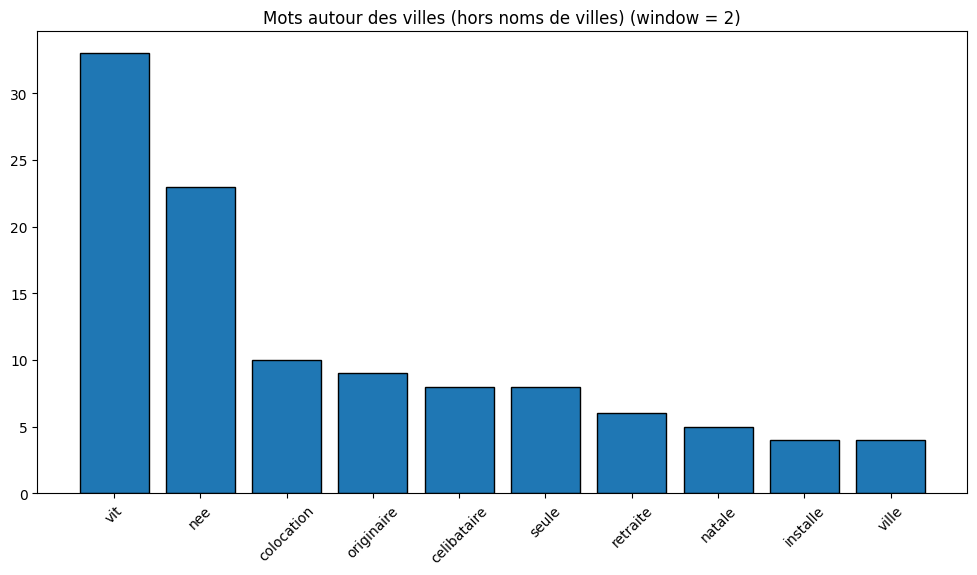

In [251]:
# Suppression des villes 
all_cities = set(city.lower() for cities in df['text_clean'].apply(extract_all_cities) for city in cities)
words_to_exclude = all_cities.union({'a'})

all_words = pd.Series([
    word
    for context_list in df['city_contexts']
    for context in context_list
    for word in context.split()
])

word_counts_df = (
    all_words[~all_words.str.lower().isin(words_to_exclude)]
    .value_counts()
    .reset_index()
)
word_counts_df.columns = ['word', 'count']

top_words_df = word_counts_df.head(10)

plt.figure(figsize=(12,6))
plt.bar(top_words_df['word'], top_words_df['count'], edgecolor="black")
plt.xticks(rotation=45)
plt.title("Mots autour des villes (hors noms de villes) (window = 2)")
plt.show()

### On va maintenant construire un regex en s'appuyant sur les formes les plus fréquentes observées.

In [252]:
def extract_birth_city_from_list(text: str, cities: list) -> Optional[str]:
    """
    Extrait la ville de naissance en cherchant uniquement dans la liste de villes valides.
    Autorise jusqu'à 2 mots entre le mot clé (nee, natale, originaire) et la ville pour capturer des formes comme "née à l'hopital de Nice"
    """
    if not cities:
        return pd.NA
    
    cities_pattern = "|".join(sorted(cities, key=len, reverse=True)) 

    # Pattern pour détecter la ville après 'nee', 'originaire', 'natale'
    patterns = [
        rf"nee(?:\s+\w+){{0,2}}\s+({cities_pattern})",
        rf"originaire(?:\s+\w+){{0,2}}\s+({cities_pattern})",
        rf"natale(?:\s+\w+){{0,2}}\s+({cities_pattern})"
    ]

    for pattern in patterns:
        match = re.search(pattern, text, flags=re.IGNORECASE)
        if match:
            return match.group(1)

    return pd.NA

df['birth_city'] = df.apply(lambda row: extract_birth_city_from_list(row['text_clean'], row['all_cities']), axis=1)

In [253]:
df[["text","all_cities","birth_city"]].head(3)

,text,all_cities,birth_city
0,"Patiente âgée de 72 ans, née à Pariis, veuve, vit seule à domicile. Ancienne enseignante.",[pariis],pariis
1,"Homme de 45 ans, marié, chauffeur routier, originaire de Lyon, hébergé avec sa famille à Lyon.","[lyon, lyon]",lyon
2,"Étudiante de 23 ans, née à l'hopital d'Annecy, célibataire, vit en colocation à Marseile.","[dannecy, marseile]",dannecy


## Nettoyage et normalisation des villes extraites

Une fois cette extraction effectuée, nous allons normaliser les résultats.  
Pour cela, nous utilisons un **fichier de référence des communes de France** fourni par l’**INSEE**, disponible sur [data.gouv.fr](https://www.data.gouv.fr/datasets/communes-et-villes-de-france-en-csv-excel-json-parquet-et-feather/).

Cette étape permet de :  
- Vérifier l’orthographe et la validité des noms de villes extraites.  
- Harmoniser les formats (ex. majuscules/minuscules, accents).  
- Filtrer les entités qui ne sont pas des villes

> Le modèle NER détecte des **LIEUX** (LOC) et pas uniquement des villes. Certaines entités extraites peuvent donc correspondre à des régions, départements, quartiers ou autres lieux. L’utilisation de la **liste de référence des communes** permet de ne conserver que les villes valides et de filtrer les autres types de lieux si nécessaire.

### 2. Création d’un dictionnaire de référence (gazetteer)

Un dictionnaire `gazetteer_dict` est construit avec :  
- **clé** = `city_clean` (forme nettoyée)  
- **valeur** = `nom_standard` (forme officielle)

In [254]:
file_path = "communes-france-2025.csv"
df_villes = pd.read_csv(
    file_path,
    usecols=["code_insee", "nom_standard"],
    dtype={"nom_standard": str},
    low_memory=False
).rename(columns={'nom_standard': 'city_official_name'})

df_villes['city_clean'] = df_villes['city_official_name'].apply(preprocess)

In [255]:
df_villes.head(3)

,code_insee,city_official_name,city_clean
0,01001,L'Abergement-Clémenciat,labergementclemenciat
1,01002,L'Abergement-de-Varey,labergementdevarey
2,01004,Ambérieu-en-Bugey,amberieuenbugey


In [256]:
gazetteer_dict = dict(zip(df_villes['city_clean'], df_villes['city_official_name']))
gazetteer_keys = list(gazetteer_dict.keys())

### 3. Correction des noms (fuzzy matching)

Nous allons maintenant comparer chaque ville extraite avec la liste des villes officielles.  
- Si une correspondance est trouvée avec un score de similarité supérieur au seuil (`80`), la fonction retourne le **nom officiel** de la ville.  
- Sinon, la valeur est laissée vide (`pd.NA`).

Cela permet de récuperer quand même le nom officiel de la ville malgré de potentiel faute de frappe : `marseile` sera bien detecté comme `Marseille`

In [257]:
def correct_city_fuzzy(city: str, gazetteer_keys: list, gazetteer_dict: dict, score_cutoff: int = 80) -> Optional[str]:
    """
    Corrige une ville détectée et retourne la forme officielle.

    Args:
        city (str): nom de la ville à corriger
        gazetteer_keys (list): liste des noms de villes de référence utilisés pour la comparaison.
        gazetteer_dict (dict): dictionnaire associant chaque clé du gazetteer à sa forme officielle.
        score_cutoff (int, optional): Score minimal de similarité (0–100) pour accepter une correction.
            Par défaut à 75.

    Returns:
        Optional[str]: 
            - Le nom officiel de la ville si une correspondance est trouvée.  
            - pd.NA sinon.
    """

    if pd.isna(city):
        return pd.NA
    
    match = process.extractOne(city, gazetteer_keys)
    
    if match and match[1] >= score_cutoff:
        return gazetteer_dict[match[0]]  # retourne la forme officielle
    return pd.NA


In [258]:
df['birth_city_clean'] = df['birth_city'].apply(lambda x: correct_city_fuzzy(x, gazetteer_keys, gazetteer_dict))

# Dataframe final :
Montrant le texte et les deux varibles extraites.

In [259]:
df[['text','age','birth_city_clean']].head(10)

,text,age,birth_city_clean
0,"Patiente âgée de 72 ans, née à Pariis, veuve, vit seule à domicile. Ancienne enseignante.",72,Paris
1,"Homme de 45 ans, marié, chauffeur routier, originaire de Lyon, hébergé avec sa famille à Lyon.",45,Lyon
2,"Étudiante de 23 ans, née à l'hopital d'Annecy, célibataire, vit en colocation à Marseile.",23,Annecy
3,"Femme, 35 ans, infirmière, natale de Toulose, vivant avec son conjoint et un enfant à Toulouse.",35,Toulouse
4,"Homme, 50 ans, ingénieur, née à Nice, marié, passionné de sport depuis quelques années.",50,Nice
5,"Patiente 29a, professeure, née à Bonneval-sur-Arc, célibataire, vit en appartement en périphérie de Lille.",29,Bonneval-sur-Arc
6,"Femme âgée de 61 ans, à la retraite, originaire de Strasbourg, vit seule à Strasbourg.",61,Strasbourg
7,"Étudiant 21 ans, née à Rennes, informaticien, en colocation",21,Rennes
8,"Résidant à Montpellier, age : 40, nee à Montpellier, chauffeur, marié, 3 enfants.",<NA>,Montpellier
9,"Patiente, 27 ans, avocate, née à Bordeaux, célibataire, vit en ville à Bordeaux.",27,Bordeaux


# Conclusion

L’extraction d’âge et de ville de naissance à partir de textes simples et relativement structurés fonctionne bien avec une approche basée sur des **regex** et règles contextuelles. 

Cette méthode est transparente et donc **facile à expliquer à des équipes non techniques**, de plus, cette approche est peu coûteuse en ressources de calcul.  

Ainsi, même si cette approche est efficace sur des textes bien formatés, elle peut être complétée par des modèles 
**NER** ou des **LLM** pour traiter des textes plus complexes et variés.

## Limites :

- **Sensibilité aux fautes et variations linguistiques** : certaines abréviations ou erreurs typographiques importantes peuvent ne pas être corrigées automatiquement.  
- **Ambiguïté sémantique** : un même nom peut désigner plusieurs entités (ex. : “Orange” = ville ou entreprise).  
- **Données restreintes** : le modèle a été testé sur un petit jeu de données, qui ne reflète pas forcément la réalité, ce qui limite la généralisation des performances.  

## Pistes d’amélioration :

1. **Fine-tuning d’un modèle NER**  
   → En utilisant un jeu de données annoté spécifique.

2. **Intégrer une vérification phonétique**  
   → Utilisation d’algorithmes de distance comme Soundex pour corriger les fautes.

3. **Mettre en place une évaluation**  
   → Créer un jeu de test annoté manuellement et mesurer les performances (précision, rappel, F1-score).

4. **Adapter le prétraitement selon la variable à extraire**  
   → Par exemple, conserver certains stopwords ou la ponctuation pour l’extraction contextuelle des villes peut être pertinent, tandis que pour l’âge, un nettoyage plus strict peut suffire.

